In [1]:
# for more advanced modelbuilding: in https://github.com/Deltares/dfm_tools/blob/main/tests/examples_workinprogress/workinprogress_modelbuilder.py
#TODO: files that are not created in this script: obsfiles, dimr.xml and the submit script (and GEBCO+GSHHS datasets)
#TODO: avoid mb. ?
#TODO: prevent prints
#TODO: check binder (no space left should be avoided)

import os
import matplotlib.pyplot as plt
plt.close('all')
import dfm_tools as dfmt
from dfm_tools import modelbuilder as mb #different import for modelbuilder since it is not exposed publicly
import hydrolib.core.dflowfm as hcdfm
import xarray as xr
import pandas as pd
import contextily as ctx


C:\Users\veenstra\Anaconda3\envs\dfm_tools_env\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# provide the token as a string
dfmt.data.get_apikeys(token=None)

apikeys found


In [3]:
# input
model_name = 'Bonaire'
dir_output = './bonaire_model'
path_style = 'unix' # windows / unix
overwrite = False # used for downloading of forcing data. Always set to True when changing the domain
paths_relative = False #TODO: currently only works with path_style='windows' (same OS as IDE)
is_geographic = True
crs = 'EPSG:4326'

# domain and resolution
lon_min, lon_max, lat_min, lat_max = -68.55, -67.9, 11.8, 12.6
dxy = 0.05

#dates as understood by pandas.period_range(). ERA5 has freq='M' (month) and CMEMS has freq='D' (day)
date_min = '2022-11-01'
date_max = '2022-11-03'
ref_date = '2022-01-01'


In [4]:
# make dirs
os.makedirs(dir_output, exist_ok=True)
dir_output_data = os.path.join(dir_output, 'data')
os.makedirs(dir_output_data, exist_ok=True)


# grid generation and refinement with meshkernelpy

Notebook with more details exposed: https://github.com/Deltares/MeshKernelPy/blob/main/docs/examples/06_mesh2d_refinement_gridded_samples_gebco.ipynb

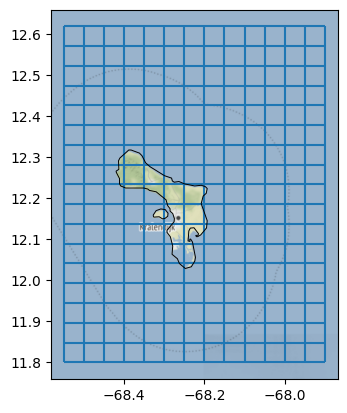

In [5]:
#generate spherical regular grid
mk_object = dfmt.make_basegrid(lon_min, lon_max, lat_min, lat_max, dx=dxy, dy=dxy, is_geographic=is_geographic)

#plot
fig, ax = plt.subplots()
mk_object.mesh2d_get().plot_edges(ax,zorder=1)
ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)


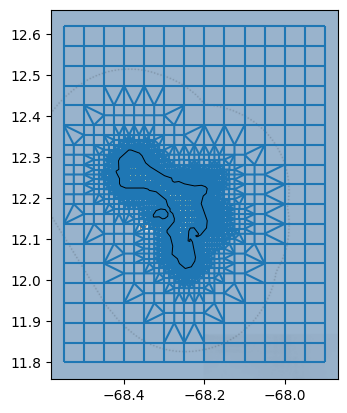

In [6]:
# refine grid

# connect to an example Bonaire cutout of the GEBCO_2021 dataset on OPeNDAP
# alternatively download your own cutout from https://download.gebco.net (use a buffer of e.g. 1 degree)
file_gebco = 'https://opendap.deltares.nl/thredds/dodsC/opendap/deltares/Delft3D/netcdf_example_files/GEBCO_2021_bonaire/GEBCO_2021_bonaire.nc'
data_bathy_sel = xr.open_dataset(file_gebco)

#refine
min_edge_size = 300 #in meters
dfmt.refine_basegrid(mk=mk_object, data_bathy_sel=data_bathy_sel, min_edge_size=min_edge_size)

#plot
fig, ax = plt.subplots()
mk_object.mesh2d_get().plot_edges(ax,zorder=1)
ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)


>> reading coastlines: 0.80 sec


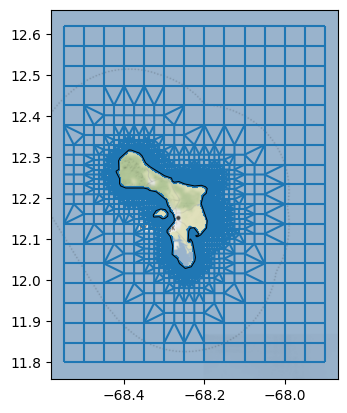

In [7]:
# remove land with GSHHS coastlines
dfmt.meshkernel_delete_withcoastlines(mk=mk_object, res='h')

#plot
fig, ax = plt.subplots()
mk_object.mesh2d_get().plot_edges(ax,zorder=1)
ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)


In [ ]:
#convert to xugrid, interpolate z-values and write to netcdf
xu_grid_uds = dfmt.meshkernel_to_UgridDataset(mk=mk_object, crs=crs)

#interp bathy
data_bathy_interp = data_bathy_sel.interp(lon=xu_grid_uds.obj.mesh2d_node_x, lat=xu_grid_uds.obj.mesh2d_node_y).reset_coords(['lat','lon']) #interpolates lon/lat gebcodata to mesh2d_nNodes dimension #TODO: if these come from xu_grid_uds (without ojb), the mesh2d_node_z var has no ugrid accessor since the dims are lat/lon instead of mesh2d_nNodes
xu_grid_uds['mesh2d_node_z'] = data_bathy_interp.elevation.clip(max=10)

#plot bathy and grid
fig, ax = plt.subplots(figsize=(8,4))
xu_grid_uds.mesh2d_node_z.ugrid.plot(ax=ax,center=False)
xu_grid_uds.grid.plot(ax=ax,linewidth=0.5,color='white',alpha=0.2)
ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)

#write xugrid grid to netcdf
netfile  = os.path.join(dir_output, f'{model_name}_net.nc')
xu_grid_uds.ugrid.to_netcdf(netfile)

# Generate plifile

In [ ]:
# generate plifile from grid extent and
grid_bounds = xu_grid_uds.grid.bounds #TODO: maybe redefine lon_min etc instead. Also possible to get bounds from mk_object?
pli_polyfile = dfmt.generate_bndpli(lon_min=grid_bounds[0], lon_max=grid_bounds[2], lat_min=grid_bounds[1], lat_max=grid_bounds[3], dlon=dxy, dlat=dxy, name=f'{model_name}_bnd')
#TODO: generate pli from mk with mk_object.mesh2d_get_mesh_boundaries_as_polygons()
poly_file = os.path.join(dir_output, f'{model_name}.pli')
pli_polyfile.save(poly_file)

polyfile_object = hcdfm.PolyFile(poly_file)
gdf_polyfile = dfmt.PolyFile_to_geodataframe_linestrings(polyfile_object,crs=crs)
ax = gdf_polyfile.plot(edgecolor='r')
ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)


# Generate boundary conditions from FES2014 and CMEMS (new ext)

In [ ]:
# new ext: initial and open boundary condition
ext_file_new = os.path.join(dir_output, f'{model_name}_new.ext')
ext_new = hcdfm.ExtModel()

#TODO: the below will not work on binder
# # FES2014 tidal components bc file
# file_bc_basename = os.path.basename(poly_file).replace('.pli','')
# ForcingModel_object = dfmt.interpolate_tide_to_bc(tidemodel='FES2014', file_pli=poly_file, component_list=None) # tidemodel: FES2014, FES2012, EOT20, GTSM4.1preliminary
# file_bc_out = os.path.join(dir_output,f'tide_{file_bc_basename}_FES2014.bc')
# ForcingModel_object.save(filepath=file_bc_out)
# boundary_object = hcdfm.Boundary(quantity='waterlevelbnd', #the FM quantity for tide is also waterlevelbnd
#                                  locationfile=poly_file,
#                                  forcingfile=ForcingModel_object)
# ext_new.boundary.append(boundary_object)

# CMEMS - download
dir_output_data_cmems = os.path.join(dir_output_data, 'cmems')
os.makedirs(dir_output_data_cmems, exist_ok=True)
for varkey in ['so','thetao','uo','vo','zos']:
    dfmt.download_CMEMS(credentials=None, #credentials=['username','password'], or create "%USERPROFILE%/CMEMS_credentials.txt" with username on line 1 and password on line 2. Register at: https://resources.marine.copernicus.eu/registration-form'
                        varkey=varkey,
                        longitude_min=lon_min, longitude_max=lon_max, latitude_min=lat_min, latitude_max=lat_max,
                        date_min=date_min, date_max=date_max,
                        dir_output=dir_output_data_cmems, file_prefix='cmems_', overwrite=overwrite)

# CMEMS - boundary conditions file (.bc) (and add to ext_bnd)
list_quantities = ['waterlevelbnd','salinitybnd','temperaturebnd','uxuyadvectionvelocitybnd'] # when supplying two waterlevelbnds to FM (tide and steric) with other quantities in between, dimrset>=2.24.00 is required or else "ERROR  : update_ghostboundvals: not all ghost boundary flowlinks are being updated" is raised (https://issuetracker.deltares.nl/browse/UNST-7011). Two waterlevelbnds need to share same physical plifile in order to be appended (https://issuetracker.deltares.nl/browse/UNST-5320).
ext_new = mb.cmems_nc_to_bc(ext_bnd=ext_new,
                            refdate_str=f'minutes since {ref_date} 00:00:00 +00:00',
                            dir_output=dir_output,
                            list_quantities=list_quantities,
                            tstart=date_min,
                            tstop=date_max, 
                            file_pli=poly_file,
                            dir_pattern=os.path.join(dir_output_data_cmems,'cmems_{ncvarname}_*.nc'))

#save new ext file
ext_new.save(filepath=ext_file_new,path_style=path_style)


In [ ]:
# plot CMEMS data

#TODO: http://localhost:8888/notebooks/docs/notebooks/preprocessing_example_hydrolib.ipynb

# Generate ERA5 meteo forcing (old ext)

In [ ]:
# old ext

# CMEMS - initial condition file
ext_file_old = os.path.join(dir_output, f'{model_name}_old.ext')
ext_old = hcdfm.ExtOldModel()

# ERA5 - download
dir_output_data_era5 = os.path.join(dir_output_data,'ERA5')
os.makedirs(dir_output_data_era5, exist_ok=True)
    
varlist_list = [['msl','u10n','v10n','chnk']]

for varlist in varlist_list:
    for varkey in varlist:
        dfmt.download_ERA5(varkey, 
                           longitude_min=lon_min, longitude_max=lon_max, latitude_min=lat_min, latitude_max=lat_max,
                           date_min=date_min, date_max=date_max,
                           dir_output=dir_output_data_era5, overwrite=overwrite)

# ERA5 meteo - convert to netCDF for usage in Delft3D FM
ext_old = mb.preprocess_merge_meteofiles_era5(ext_old=ext_old,
                                              varkey_list = varlist_list,
                                              dir_data = dir_output_data_era5,
                                              dir_output = dir_output,
                                              time_slice = slice(date_min, date_max))

ext_old.save(filepath=ext_file_old,path_style=path_style)


In [ ]:
# plot ERA5 data example

#TODO

# Generate mdu file

In [ ]:
# initialize mdu file and update settings
mdu_file = os.path.join(dir_output, f'{model_name}.mdu')
mdu = hcdfm.FMModel()

# mdu.geometry.netfile = netfile
# mdu.geometry.bedlevuni = 5
# mdu.geometry.kmx = 20
# mdu.geometry.layertype = 1
# mdu.geometry.numtopsig = 20
# mdu.geometry.sigmagrowthfactor = 1.2
# mdu.geometry.dxdoubleat1dendnodes = 1
# mdu.geometry.changevelocityatstructures = 0
# mdu.geometry.changestructuredimensions = 1
# mdu.geometry.numtopsiguniform = 1
# mdu.geometry.dztop = 5.0
# mdu.geometry.floorlevtoplay = -5.0
# mdu.geometry.dztopuniabovez = -100.0
# mdu.geometry.keepzlayeringatbed = 2

# mdu.numerics.tlfsmo = 86400
# mdu.numerics.izbndpos = 1
# mdu.numerics.mintimestepbreak = 0.1
# mdu.numerics.keepstbndonoutflow = 1

# mdu.physics.tidalforcing = 1
# mdu.physics.salinity = 1
# mdu.physics.temperature = 5
# mdu.physics.initialsalinity = 33.8
# mdu.physics.temperature = 5
# mdu.physics.initialtemperature = 29.3
# mdu.physics.rhomean = 1023
# mdu.physics.secchidepth = 4
# mdu.physics.salimax = 50
# mdu.physics.tempmax = 50

# mdu.wind.icdtyp = 4
# mdu.wind.rhoair = 1.2265
# mdu.wind.relativewind = 0.5
# mdu.wind.pavbnd = 101330

mdu.external_forcing.extforcefile = ext_file_old
mdu.external_forcing.extforcefilenew = ext_new #TODO: extfile not found with path_style='unix': https://github.com/Deltares/HYDROLIB-core/issues/516, but workaround is with extobject instead of extpath.

mdu.time.refdate = pd.Timestamp(ref_date).strftime('%Y%m%d')
mdu.time.tunit = 'S'
mdu.time.dtmax = 30
mdu.time.startdatetime = pd.Timestamp(date_min).strftime('%Y%m%d%H%M%S')
mdu.time.stopdatetime = pd.Timestamp(date_max).strftime('%Y%m%d%H%M%S')
mdu.time.autotimestep = 3

#mdu.output.obsfile = [os.path.join(dir_output,x) for x in ['osm_beach_centroids_offset_bonaire.xyn','stations_obs.xyn','test_obs.xyn']]
mdu.output.hisinterval = [60]
mdu.output.mapinterval = [1800]#[86400]
mdu.output.rstinterval = [0]
mdu.output.statsinterval = [3600]

#%% export model
mdu.save(mdu_file,path_style=path_style)

#TODO: if windows/unix newextfile validation is fixed, use relative paths in .ext and in .mdu files (this is a workaround that only works for same-OS so windows paths)
if paths_relative:
    for filename in [mdu_file,ext_file_old,ext_file_new]:
        with open(filename, 'r') as file :
            filedata = file.read()
        filedata = filedata.replace(dir_output.replace('\\','/')+'/', '') #dir_output or os.path.dirname(mdu_file)
        with open(filename, 'w') as file:
            file.write(filedata)



# check written files in model directory

In [ ]:
os.listdir(dir_output)

In [ ]:
status = os.system('dir')